# Aplicación de clustering espacialmente restringido 

Se muestra una aplicación de los métodos de clustering espacialmente restringido a los casos de COVID en los departamentos/partidos de Argentina.

## Instalación 

In [1]:
from SDEC.datos.codigos.lectura_datos import *
import SDEC.regionalizacion.regionalizacion as reg
import matplotlib.pyplot as plt
import SDEC.regionalizacion.deep_cluster as dc
from sklearn.cluster import KMeans, AgglomerativeClustering
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import numpy2ri,pandas2ri
from rpy2.robjects import default_converter


%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython


Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_FileGDB.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_MSSQLSpatial.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_OCI.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Files\GeoDa Software\ogr_PG.dll
126: The specified module could not be found.

Can't load requested DLL: C:\Program Fil

## Lectura de datos

In [2]:
covid,geo, centroides, codiprov,covid_acum,personas = df_covid()

El mes desde el cuál todos los dptos tienen al menos 1 contagiado es: 2021-01


In [3]:
cov = reg.Datos(covid, ['clasificac','fallecido'], 'personas')
df = cov.convertir_a_df(cov.panel_df,['clasificac','fallecido'])
# calculamos la proporcion de cada variable en cada periodo del total de la población
prop = df.iloc[:,:-1].values/df.personas.values.reshape(-1,1)
prop.shape

(525, 34)

In [4]:
from sklearn.preprocessing import StandardScaler
st = StandardScaler()
prop_st = st.fit_transform(prop)


In [5]:
geo_prop = gpd.GeoDataFrame(prop,columns =  np.array(range(34), str), geometry = geo.reset_index().geometry)
geo_prop.to_file("SDEC/datos/datos/geo_prop.shp")

c:\Anaconda3\envs\covid2\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## Cálculo de métodos de clustering espacial

En este caso se aplican 3 de los métodos más utilizados en la literatura que son provistos por el programa en R, rgeoda

R[write to console]: Loading required package: sp

R[write to console]: Loading required package: spData

R[write to console]: To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

R[write to console]: Loading required package: sf

R[write to console]: Linking to GEOS 3.9.1, GDAL 3.2.1, PROJ 7.2.1

R[write to console]: Loading required package: digest

R[write to console]: 
Attaching package: 'rgeoda'


R[write to console]: The following object is masked from 'package:spdep':

    skater




Reading layer `geo_prop' from data source 
  `D:\Archivos\Codigos\clustering espacial\SDEC\datos\datos\geo_prop.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 525 features and 34 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 2952701 ymin: 3898217 xmax: 4740787 ymax: 7596382
Projected CRS: POSGAR 2007 / Argentina 3
aaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skateraaa0after gda_skater

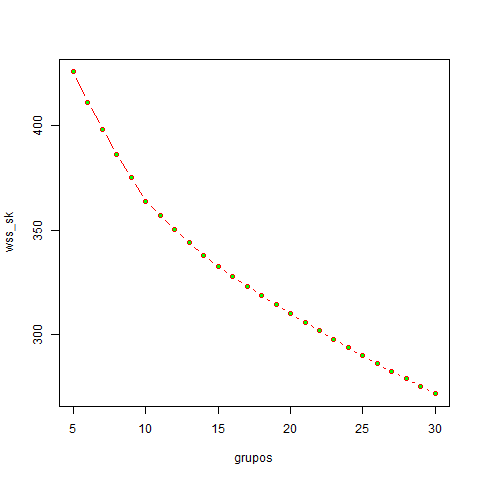

In [6]:
%%R
library(spdep)
library(rgeoda)
library(digest)

covid <- st_read("SDEC/datos/datos/geo_prop.shp")
w_knn <- knn_weights(covid,6)
set.seed(213)

elegir_grupos <- function(datos, metodo, grupos) {
  whithins <- numeric()
  for (i in 1:length(grupos)){
    m <- metodo(grupos[i],w_knn, datos)
    #m <- metodo(datos, grupos[i])
    whithins[i] <- mean(m$`Within-cluster sum of squares`)
  }
  return(whithins)}
grupos = 5:30
wss_sk <- elegir_grupos(covid, skater, grupos = grupos)

plot(grupos,wss_sk, type = "b", cex = 1, pch = 21, bg = "green", col = "red", lwd = 1)

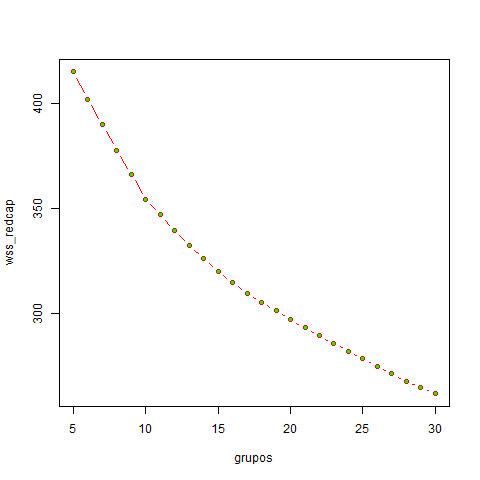

In [7]:
%%R
wss_redcap <- elegir_grupos(covid, redcap, grupos)
plot(grupos,wss_redcap, type = "b", cex = 1, pch = 21, bg = "green", col = "red", lwd = 1)


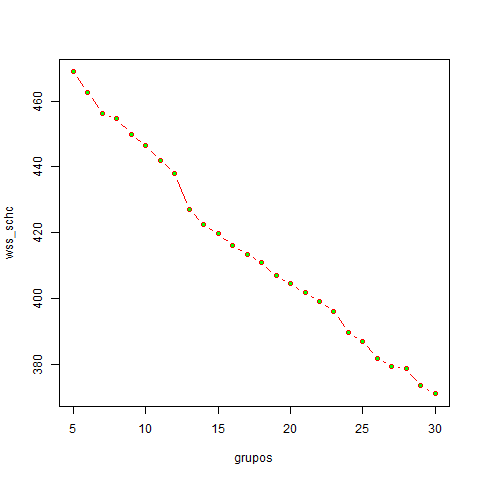

In [8]:
%%R
wss_schc <- elegir_grupos(covid, schc, grupos)
plot(grupos,wss_schc, type = "b", cex = 1, pch = 21, bg = "green", col = "red", lwd = 1)


In [9]:
%%R
# la cantidad de grupos parece ser 10 para skater y redcap  13 para SCHC

sk <- skater(10, w_knn, covid)
redcap <- redcap(10,w_knn, covid)
sch <- schc(13, w_knn, covid)

rdos <- matrix(nrow = 525)
rdos <- as.data.frame(rdos)
rdos['skater'] <- sk$Clusters
rdos['redcap'] <- redcap$Clusters
rdos['schc'] <- sch$Clusters
rdos <- rdos[,2:4]


aaa0after gda_skater

In [10]:
rdos_en_r = ro.r['rdos']
with localconverter(default_converter+pandas2ri.converter):
    rdo_rgeoda = ro.conversion.rpy2py(rdos_en_r)
rdo_rgeoda

,skater,redcap,schc
1,6,6,13
2,3,3,1
3,3,3,1
4,6,6,1
5,3,3,1
...,...,...,...
521,2,1,1
522,2,1,1
523,2,1,1
524,5,4,1


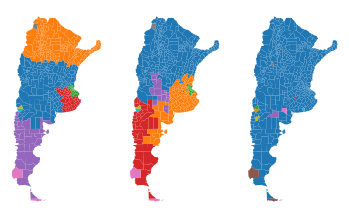

In [11]:
fig,ax = plt.subplots(1,3)
figsize =(12,10)
geo_prop.plot(rdo_rgeoda.skater.values,categorical = True, ax = ax[0], figsize = figsize)
geo_prop.plot(rdo_rgeoda.redcap.values,categorical = True, ax = ax[1], figsize = figsize)
geo_prop.plot(rdo_rgeoda.schc.values,categorical = True, ax = ax[2], figsize = figsize)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

## Aplicación de spacial deep embeding clustering


In [12]:
sc = dc.sdec(10, [17,17])

In [13]:
cov.matriz_W(6)
W = cov.W_knn

c:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)
c:\Anaconda3\envs\covid2\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [14]:
X1 = prop[:,:17]
X2 = prop[:,17:]*1000
sc.gen_modelo()
sc.train_autoencoder([X1,X2],prop)
sc.ajustar_modelo([X1,X2], W.sparse)


<AxesSubplot:>

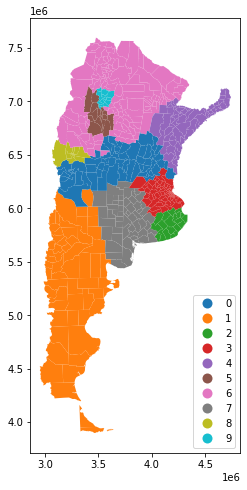

In [15]:
geo_prop.plot(sc.y_pred, figsize = (10,8), categorical = True,legend = True,legend_kwds = {'loc':'lower right'})

<AxesSubplot:>

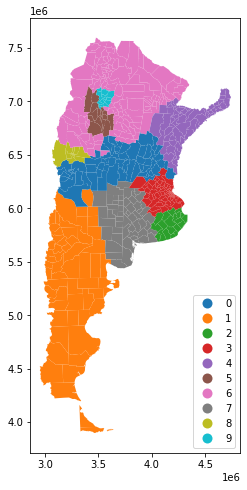

In [16]:
geo_prop.plot(sc.y_pred, figsize = (10,8), categorical = True,legend = True,legend_kwds = {'loc':'lower right'})

In [17]:
from sklearn.metrics import *

def metricas_intrinsecas(datos, grupos):
    sil = round(silhouette_score(datos,grupos),5)
    cal = round(calinski_harabasz_score(datos,grupos),5)
    dav = round(davies_bouldin_score(datos, grupos),5)
    rdo = pd.DataFrame([sil,cal,dav], index = ['Siluetas', 'Kalinski','Davies'])
    return rdo

In [18]:
r_sc = metricas_intrinsecas(prop, sc.y_pred)
r_sk = metricas_intrinsecas(prop, rdo_rgeoda.skater)
r_rc = metricas_intrinsecas(prop, rdo_rgeoda.redcap)
r_schc = metricas_intrinsecas(prop, rdo_rgeoda.schc)

rdos = pd.concat([r_sc,r_sk,r_rc,r_schc], axis = 1)
rdos.columns = ['SDEC', 'skater','REDCAP','SCHC']
rdos


,SDEC,skater,REDCAP,SCHC
Siluetas,-0.09004,-0.06933,-0.03483,-0.30296
Kalinski,20.18019,19.41592,22.26178,3.94406
Davies,4.07830,2.57301,1.87669,0.76681


Calculando las metricas sobre los autoencoders ahí si arroja buenos resultados SDEC y los otros siguen siendo malos

In [19]:
encoders = sc.encoder.predict([X1,X2])
r_enco_sc = metricas_intrinsecas(encoders, sc.y_pred)
r_enco_sk = metricas_intrinsecas(encoders, rdo_rgeoda.skater)
r_enco_rc = metricas_intrinsecas(encoders, rdo_rgeoda.redcap)
r_enco_schc = metricas_intrinsecas(encoders, rdo_rgeoda.schc)

rdos_enco = pd.concat([r_enco_sc,r_enco_sk,r_enco_rc,r_enco_schc], axis = 1)
rdos_enco.columns = ['SDEC', 'skater','REDCAP','SCHC']
rdos_enco


,SDEC,skater,REDCAP,SCHC
Siluetas,0.39624,-0.40169,-0.35338,-0.68578
Kalinski,1472.68185,68.81467,96.54850,1.61454
Davies,2.25052,2.24549,3.47575,0.84105


In [20]:
pred = sc.autoencoder.predict([X1,X2])
mean_squared_error(prop, pred)

0.00017098752966044573

-0.21662883890077334 0.0


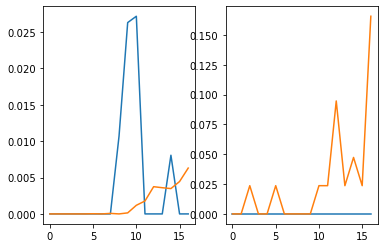

In [21]:
v = 356
cont_pred, fall_pred = pred[v,:17],pred[v,17:]*1000
cont_real, fall_real = prop[v,:17],prop[v,17:]*1000
print(r2_score(cont_pred, cont_real),r2_score(fall_pred, fall_real))
fig, ax = plt.subplots(1,2)
ax[0].plot(cont_pred)# = plt.plot(cont_pred)
ax[0].plot(cont_real)
ax[1].plot(fall_pred)
ax[1].plot(fall_real)

In [22]:
X1 = prop_st[:,:17]
X2 = prop_st[:,17:]
sc.gen_modelo()
sc.train_autoencoder([X1,X2],prop_st)
sc.ajustar_modelo([X1,X2], W.sparse)

In [23]:
metricas_intrinsecas(prop_st,sc.y_pred)

,0
Siluetas,-0.07017
Kalinski,15.78145
Davies,4.44265


In [24]:
pred = sc.autoencoder.predict([X1,X2])
mean_squared_error(prop_st, pred)

0.9874216672064143

In [25]:
np.corrcoef(prop[:,:17])

array([[ 1.        ,  0.75495625,  0.87498942, ...,  0.34894383,
        -0.05314991,  0.00305268],
       [ 0.75495625,  1.        ,  0.88020301, ...,  0.62540376,
         0.10479183,  0.36939603],
       [ 0.87498942,  0.88020301,  1.        , ...,  0.49738199,
         0.08097394,  0.14472167],
       ...,
       [ 0.34894383,  0.62540376,  0.49738199, ...,  1.        ,
         0.57005728,  0.57718621],
       [-0.05314991,  0.10479183,  0.08097394, ...,  0.57005728,
         1.        ,  0.71793655],
       [ 0.00305268,  0.36939603,  0.14472167, ...,  0.57718621,
         0.71793655,  1.        ]])

In [26]:
np.corrcoef(prop_st[:,:17])

array([[ 1.        ,  0.51272599,  0.5349263 , ..., -0.35613229,
        -0.20297204, -0.12169725],
       [ 0.51272599,  1.        ,  0.75709957, ..., -0.47749898,
        -0.18460445,  0.37021746],
       [ 0.5349263 ,  0.75709957,  1.        , ..., -0.5710583 ,
        -0.17120599, -0.03986559],
       ...,
       [-0.35613229, -0.47749898, -0.5710583 , ...,  1.        ,
         0.50911102,  0.17569559],
       [-0.20297204, -0.18460445, -0.17120599, ...,  0.50911102,
         1.        ,  0.19977651],
       [-0.12169725,  0.37021746, -0.03986559, ...,  0.17569559,
         0.19977651,  1.        ]])

-254.51503744564326 -208.90072766720291


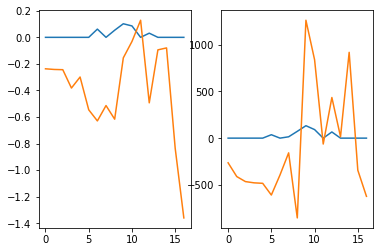

In [27]:
v = 16
cont_pred, fall_pred = pred[v,:17],pred[v,17:]*1000
cont_real, fall_real = prop_st[v,:17],prop_st[v,17:]*1000
print(r2_score(cont_pred, cont_real),r2_score(fall_pred, fall_real))
fig, ax = plt.subplots(1,2)
ax[0].plot(cont_pred)# = plt.plot(cont_pred)
ax[0].plot(cont_real)
ax[1].plot(fall_pred)
ax[1].plot(fall_real)

(<AxesSubplot:>, <AxesSubplot:>)

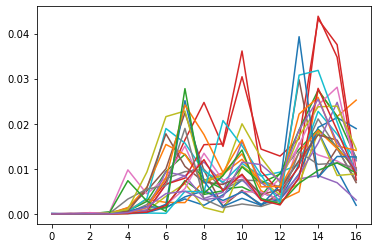

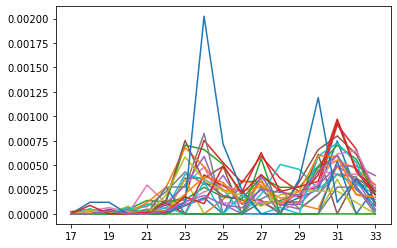

In [72]:
grupo = 6
geo_prop.iloc[:,:17][sc.y_pred == grupo].T.plot(legend = False),geo_prop.iloc[:,17:34][sc.y_pred == grupo].T.plot(legend = False)

<AxesSubplot:>

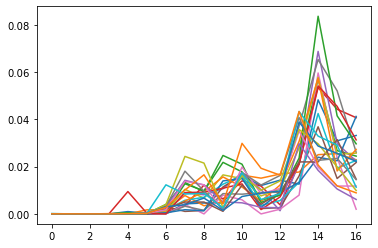

In [69]:
geo_prop.iloc[:,:17][(rdo_rgeoda.redcap == 5).values].T.plot(legend = False)

## Coeficiente de localización 

In [28]:
import SDEC.coef_loc.regiones as rg

In [29]:
arg = rg.paneldf_to_region(cov.panel_df, poblacion = 'personas',grupos = sc.y_pred, variables = ['clasificac','fallecido'])

In [30]:
arg[0].calc_lq().shape

(10, 17)

In [31]:
arg[0].calc_ind_lq(),arg[1].calc_ind_lq()

(0.09673202614379084, 0.32026143790849676)

In [32]:
arg[0].calc_ind_lq('b'),arg[1].calc_ind_lq('b')

(0.6535947712418301, 0.6522875816993463)

In [33]:
ter_redcap = rg.paneldf_to_region(cov.panel_df, poblacion = 'personas',grupos = rdo_rgeoda.redcap.values, variables = ['clasificac','fallecido'])
ter_redcap[0].calc_ind_lq(),ter_redcap[1].calc_ind_lq()

(0.17124183006535948, 0.4156862745098039)

In [34]:
ter_redcap[0].calc_ind_lq('b'),ter_redcap[1].calc_ind_lq('b')

(0.3176470588235294, 0.3333333333333333)

In [35]:
np.mean(arg[0].calc_homog_particion()),np.mean(arg[1].calc_homog_particion())

(240901.32357672096, 200.36021616263707)

In [36]:
np.mean(ter_redcap[0].calc_homog_particion()),np.mean(ter_redcap[1].calc_homog_particion())

(177114.89907250766, 142.83821348020666)

In [37]:
I = np.array(arg[0].intervalos('m'))

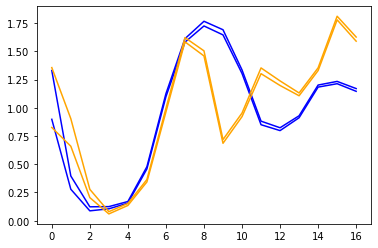

In [38]:
plt.plot(I[:,0,0], color = 'blue')
plt.plot(I[:,0,1], color = 'blue')
plt.plot(I[:,4,0], color = 'orange')
plt.plot(I[:,4,1], color = 'orange')

In [39]:
I = np.array(arg[0].intervalos('b'))

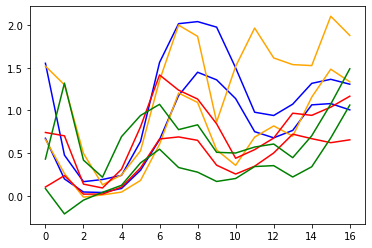

In [40]:
plt.plot(I[:,0,0], color = 'blue')
plt.plot(I[:,0,1], color = 'blue')
plt.plot(I[:,4,0], color = 'orange')
plt.plot(I[:,4,1], color = 'orange')
plt.plot(I[:,1,0], color = 'red')
plt.plot(I[:,1,1], color = 'red')
plt.plot(I[:,2,0], color = 'green')
plt.plot(I[:,2,1], color = 'green')

In [41]:
import seaborn as sns

In [42]:
I_rc = np.array(ter_redcap[0].intervalos('b'))

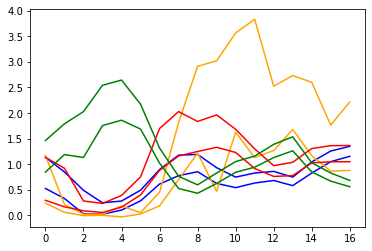

In [43]:
plt.plot(I_rc[:,0,0], color = 'blue')
plt.plot(I_rc[:,0,1], color = 'blue')
plt.plot(I_rc[:,4,0], color = 'orange')
plt.plot(I_rc[:,4,1], color = 'orange')
plt.plot(I_rc[:,1,0], color = 'red')
plt.plot(I_rc[:,1,1], color = 'red')
plt.plot(I_rc[:,2,0], color = 'green')
plt.plot(I_rc[:,2,1], color = 'green')

In [44]:
arg[0].calc_ind_lq('b', prom = False)

array([0.86666667, 0.91111111, 0.82222222, 0.77777778, 0.77777778,
       0.71111111, 0.8       , 0.51111111, 0.42222222, 0.35555556,
       0.42222222, 0.48888889, 0.66666667, 0.53333333, 0.66666667,
       0.73333333, 0.6       ])

In [45]:
ter_redcap[0].calc_ind_lq('b', prom = False)

array([0.37777778, 0.17777778, 0.4       , 0.15555556, 0.24444444,
       0.26666667, 0.24444444, 0.28888889, 0.17777778, 0.31111111,
       0.26666667, 0.31111111, 0.53333333, 0.48888889, 0.44444444,
       0.31111111, 0.33333333])